# Imports

In [237]:
# import required modules 
import requests, json
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import datetime
import matplotlib.pyplot as plt

# Dummy data

In [275]:
np.random.seed(429)
base = datetime.datetime.today()
numsamples = 100
train_prefs = pd.DataFrame({
    "dt" : [base - datetime.timedelta(days=x) for x in range(numsamples)],
    "temp": np.random.normal(loc = 293, scale = 5, size = numsamples), 
    "humidity": 50 + np.random.normal(scale = 25, size = numsamples),
    "clouds": 50 + np.random.normal(scale = 25, size = numsamples), 
    "wind_speed": np.random.gamma(shape = 5, size = numsamples),
    "rain" : [0 if i < 0 else i for i in np.random.normal(scale = 10, size = numsamples)],
    "snow" : [0 if i < 0 else i for i in np.random.normal(scale = 10, size = numsamples)]
})
train_prefs['feels_like'] = train_prefs['temp'] + np.random.normal(scale = 2, size = numsamples)
train_prefs['rating'] = [np.random.binomial(1, .95) if i > 293 else 
              np.random.binomial(1, .05) for i in train_prefs['temp']]
train_prefs['rating'] = train_prefs['rating'].replace(0, -1)


test_prefs = pd.DataFrame({
    "dt" : [base - datetime.timedelta(days=x) for x in range(numsamples)],
    "temp": np.random.normal(loc = 293, scale = 5, size = numsamples), 
    "humidity": 50 + np.random.normal(scale = 25, size = numsamples),
    "clouds": 50 + np.random.normal(scale = 25, size = numsamples), 
    "wind_speed": np.random.gamma(shape = 5, size = numsamples),
    "rain" : [0 if i < 0 else i for i in np.random.normal(scale = 10, size = numsamples)],
    "snow" : [0 if i < 0 else i for i in np.random.normal(scale = 10, size = numsamples)]
})
test_prefs['feels_like'] = test_prefs['temp'] + np.random.normal(scale = 2, size = numsamples)

test_prefs.head()

,dt,temp,humidity,clouds,wind_speed,rain,snow,feels_like
0,2020-10-24 20:27:34.485600,300.469303,62.707139,18.955416,4.253614,0.000000,0.000000,298.471672
1,2020-10-23 20:27:34.485600,296.618688,19.740569,43.075172,1.975134,0.000000,34.440730,296.057075
2,2020-10-22 20:27:34.485600,297.975478,33.560630,60.475985,5.327826,1.091643,7.950884,300.101407
3,2020-10-21 20:27:34.485600,289.096899,14.254232,102.249271,4.318032,6.535955,0.000000,288.530578
4,2020-10-20 20:27:34.485600,300.570511,43.947067,52.202776,5.591904,7.094828,12.008798,301.292910


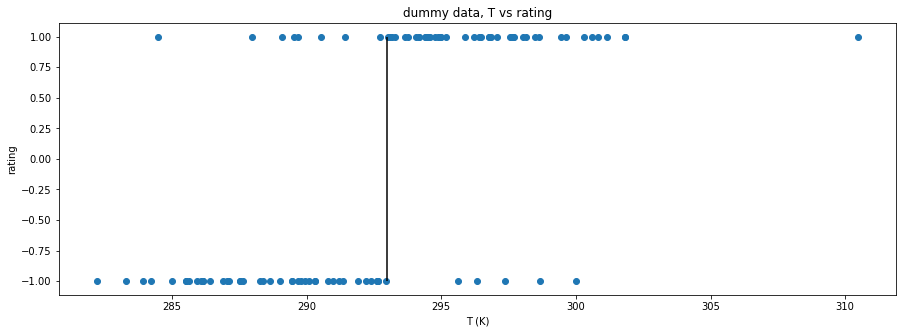

In [212]:
plt.figure(figsize = (15, 5))
plt.scatter(train_prefs['temp'], train_prefs['rating'])
plt.title('dummy data, T vs rating')
plt.vlines(293, -1, 1)
plt.xlabel('T (K)')
plt.ylabel('rating');

# Pulling weather data

Code from https://www.geeksforgeeks.org/python-find-current-weather-of-any-city-using-openweathermap-api/

In [58]:
def get_weather(city_name):
    """
    Takes a city name, and returns a dictionary of weather and location data. 
    """
    # Python program to find current  
    # weather details of any city 
    # using openweathermap api 

    # Enter your API key here 
    api_key = "9291be5e6daedb7e3a4a03f8857a8d5f"

    # base_url variable to store url 
    base_url = "http://api.openweathermap.org/data/2.5/weather?"

    # complete_url variable to store 
    # complete url address 
    complete_url = base_url + "appid=" + api_key + "&q=" + city_name 

    # get method of requests module 
    # return response object 
    response = requests.get(complete_url) 

    # json method of response object  
    # convert json format data into 
    # python format data 
    x = response.json() 
    
    # Now x contains list of nested dictionaries 
    # Check the value of "cod" key is equal to 
    # "404", means city is found otherwise, 
    # city is not found 
    if x["cod"] != "404": 
        output_dict = {}
        output_dict['temp'] = x['main']['temp']
        output_dict['feels_like'] = x['main']['feels_like']
        output_dict['humidity'] = x['main']['humidity']
        output_dict['clouds'] = x['clouds']['all']
        output_dict['wind_speed'] = x['wind']['speed']
        if 'rain' not in x.keys():
            output_dict['rain'] = 0
        else:
            output_dict['rain'] = x['rain']['1h']
        if 'snow' not in x.keys():
            output_dict['snow'] = 0
        else:
            output_dict['snow'] = x['snow']['1h']
        return output_dict 
    else: 
        print(" City Not Found ") 
        return None

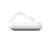

In [318]:
from PIL import Image
import requests
from io import BytesIO
url = 'http://openweathermap.org/img/w/03n.png'
response = requests.get(url)
img = Image.open(BytesIO(response.content))
img

## Tests

In [59]:
atx = get_weather("Austin")
atx

{'temp': 291.47,
 'feels_like': 289.99,
 'humidity': 48,
 'clouds': 90,
 'wind_speed': 1.15,
 'rain': 0,
 'snow': 0}

In [77]:
phx = get_weather("Phoenix")
phx

{'temp': 302.68,
 'feels_like': 300.61,
 'humidity': 25,
 'clouds': 90,
 'wind_speed': 2.1,
 'rain': 0,
 'snow': 0}

# Returning weather assessment

A function for returning the predicted response of the user to the weather (negative or positive)

In [269]:
def assess_weather(weather_dict, user_preferences = None):
    """
    Takes as input a dictionary with the weather parameters of interest:
        - temp
        - feels_like
        - humidity
        - clouds 
        - wind_speed
        - rain
        - snow
    Current implementation looks for a dictionary with a 'main' key, coresponding to a subdictionary
        which contains a 'temp' entry 
    Also takes user_preferences, a pandas dataframe with the same columns as weather_dict, but also has columns
        - dt
        - rating
    If user_preferences = None, use default temp cutoff
    
    Returns -1 or 1, for negative or positive predicted user response to weather.
    """
    temp = weather_dict['feels_like'] # temperature in Kelvin
    if user_preferences is None or len(user_preferences) < 50:
        if temp > 294: # 294K, 70 F 
            return 1
        else:
            return -1
    else:
        learned_preference_model = learn_preferences(user_preferences)
        return learned_preference_model.predict(pd.DataFrame(weather_dict, index =[0]))

## Learning user preferences

Suppose that a user's opinion of the weather is based on the average temperature, temperature spread, precipitation, and cloud coverage. 
Further suppose that a user's weather preferences may be similar to the preferences in their region (for cold start). 

We can simply then either train on a user given their data, or if it's too small, append similar data from their region and treat that as the user preference. 

In [ ]:
2877392346
3758465986

In [371]:
def learn_preferences(user_preferences):
    """
    Trains and returns a logistic regression model based on the user_preferences, which is a pd DataFrame with:
        - dt
        - temp
        - feels_like
        - humidity
        - clouds 
        - wind_speed
        - rain
        - snow
        - rating
    """
    X, y = user_preferences.drop(['rating', 'dt'], axis = 1), user_preferences['rating']
    lg = LogisticRegression(max_iter = 1000, C = .1)
    cvals = np.linspace(0.1, 0.2, 4)
    clf = GridSearchCV(lg, [{'C':cvals}], cv = 3)
    return clf.fit(X, y)

In [372]:
fitted_params = learned_test_prefs.best_params_
fitted_params

{'C': 0.13333333333333333}

In [373]:
newmodel = LogisticRegression()
newmodel.coef_ = fitted_params

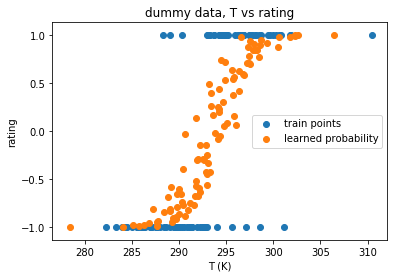

In [374]:
learned_test_prefs = learn_preferences(train_prefs)
pred_ratings = learned_test_prefs.predict_proba(test_prefs.drop('dt', axis = 1))
plt.scatter(train_prefs['temp'], train_prefs['rating'], label = 'train points')
plt.scatter(test_prefs['temp'], [i[1] * 2 - 1 for i in pred_ratings], label = 'learned probability')
plt.title('dummy data, T vs rating')
plt.legend()
plt.xlabel('T (K)')
plt.ylabel('rating');

In [344]:
new_pred_ratings = newmodel.predict_proba(test_prefs.drop('dt', axis = 1))

plt.scatter(train_prefs['temp'], train_prefs['rating'], label = 'train points')
plt.scatter(test_prefs['temp'], [i[1] * 2 - 1 for i in new_pred_ratings], label = 'learned probability')
plt.title('dummy data, T vs rating')
plt.legend()
plt.xlabel('T (K)')
plt.ylabel('rating');

AttributeError: 'LogisticRegression' object has no attribute 'classes_'

## Tests

In [250]:
assess_weather(atx, None)

-1

In [251]:
assess_weather(phx, None)

1

In [279]:
assess_weather(atx, train_prefs)

array([-1], dtype=int64)

# Recommendation on sad days

For this, we can have a few simple options
* Inspirational quote
    * Weather related quotes? 
    * Fun facts
* Recommendation for mitigating the negative effect of the weather directly (umbrella, sunscreen, etc) 
* Netflix recommendation

In [286]:
atx

{'temp': 291.47,
 'feels_like': 289.99,
 'humidity': 48,
 'clouds': 90,
 'wind_speed': 1.15,
 'rain': 0,
 'snow': 0}

In [316]:
def bad_weather_rec(weather):
    """
    To be called in case of user-disliked weather. 
    Returns (currently) just a fun pun to be displayed instead of actual weather data. 
    """
    output = ""
    if weather['rain'] > 0:
        output +=  np.random.choice([
            "People using umbrellas always seem to be under the weather.\n\n"
        ])
    if weather['snow'] > 0:
        output += np.random.choice([
            "The snowstorm arrived at a fortuitous moment. \nIt was white on time.\n\n"
        ])
    if weather['clouds'] > 50:
        output += np.random.choice([
            "What did one raindrop say to the other? \nTwo’s company, three’s a cloud. \n\n"
        ])
    if weather['feels_like'] < 273:
        output += np.random.choice([
            "Cold winter weather is snow laughing matter!\n\n"
        ])
    if weather['feels_like'] > 303:
        output += np.random.choice([
            "I received a message from the sun, it was enlightening.\n\n"
        ])
    if weather['humidity'] > 50: 
        output += np.random.choice([
            "The secretary left me a message saying humidity will hit 90% today... She wrote it on a sticky note \n\n"
        ])
    if weather['wind_speed'] > 30:
        output += np.random.choice([
            "Coming up with weather puns is a breeze. \n\n"
        ])
    return output
    

In [317]:
s = bad_weather_rec(atx)
print(s)

What did one raindrop say to the other? 
Two’s company, three’s a cloud. 




# Give result to user

* Assume the existence of a function `get_user_preferences` that takes a UUID and returns a Pandas DataFrame with columns `dt, temp, humidity, wind_speed, clouds, rain, rating` and a row for each time the user rated the weather.
* Assume also the existence of a function `get_city` that takes a UUID and returns the city associated with the user. 

In [281]:
def get_city(userID):
    """
    Takes userID, looks up their city from DB
    """
#     TODO: make this work properly
    return "Austin"

In [282]:
def get_user_preferences(userID):
    """
    Takes userID, returns a pandas df of their user preferences
    """
#     TODO: make this work properly
    return train_prefs

In [283]:
def main(userID):
    user_preferences = get_user_preferences(userID)
    city = get_city(userID)   
    weather = get_weather(city)
    
#     TODO
#     similar_preferences = get_similar_preferences(userID, numsamples = 100)
#     TODO
    
    user_assessment = assess_weather(weather, user_preferences)
    if user_assessment == 1:
        return weather
    elif user_assessment == -1:
        return bad_weather_rec()

In [285]:
main('asdf')

'The greatest glory in living lies not in never falling, but in rising every time we fall.'